# 7. Retrieval Augmented Generation

In [18]:
from langchain.chat_models import init_chat_model
model = init_chat_model("gpt-4o-mini", model_provider="openai")

## 7.1 Introduction to RAG (Retrieval Augmented Generation)

- Retrieval-Augmented Generation (RAG) is a technique where an LLM retrieves relevant external knowledge (e.g., from documents or databases) and incorporates it into its prompt to generate more accurate and grounded responses.
- A typical RAG application has two main components:

    - **Indexing**: a pipeline for ingesting data from a source and indexing it. _This usually happens offline_.

    - **Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.
 
### 7.1.1 Indexing

We have looked at Indexing in an earlier tutorial (Semantic Search). The steps are summarised below:

- **Load**: First we need to load our data. This is done with Document Loaders.
- **Split**: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
- **Store**: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a VectorStore and Embeddings model.

### 7.1.2 Retrieval

- **Retrieve**: Given a user input, relevant splits are retrieved from storage using a Retriever.
- **Generate**: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data


## 7.2 RAG Over Documents

### 7.2.1 Setup

In [19]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv

    load_dotenv()
except ImportError:
    pass

assert os.environ["LANGSMITH_TRACING"] is not None
assert os.environ["LANGSMITH_API_KEY"] is not None
assert os.environ["LANGSMITH_PROJECT"] is not None
assert os.environ["OPENAI_API_KEY"] is not None


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)

## 7.2.2 Load Document

For this example, we will perform RAG over an HTML document.  We will use
- `WebBaseLoader` to load HTML from web URLs
- `BeautifulSoup` to parse it to text. In this case only HTML tags with class “post-content”, “post-title”, or “post-header” are relevant, so we’ll remove all others.

In [21]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [22]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### 7.2.3 Split Document

Our loaded document is over 42k characters which is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

In [23]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


### 7.2.4 Storing Documents

In [24]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['677aa2bf-7f77-4c21-8d02-84236e232168', '8ff3c00e-24c8-4b15-a6e2-68b0d6ed5442', 'c468cad2-cc5b-44e3-b542-034b603b0c46']


### 7.2.5 Retrieval and Generation

We will create a simple application that: 
1. Takes a user question,
2. Searches for documents relevant to that question
3. passes the retrieved documents and initial question to a model
4. Returns an answer.

The prompt we'll use is from Lanchain's prompt library [here](https://smith.langchain.com/hub/rlm/rag-prompt).
For step 3 and 4, we will use LangGraph

In [25]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [26]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

We have 2 steps in our graph: retrieval and generation. We will create 2 notes for these.
- The `retrieve` node will search the vector store for matching documents. Matching documents will be set on the state.
- The `generate` node willl invoke the llm passing the question, and similar documents.
- We store the answer in the state

In [27]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Let's put the `retrieval` and `generate` steps in the graph and this order.

In [28]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

To visualize our graph:

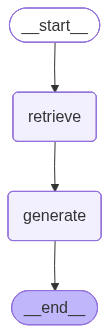

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='4ea8d275-db47-4637-a522-4c4637d07004', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

#### 7.2.5.1 Using a custom prompt

Below is an example of using a prompt template:

In [33]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='4ea8d275-db47-4637-a522-4c4637d07004', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

## 7.3 Query Analysis

- Query Analysis is the process of employing models to transform or construct optimized search queries from raw user input.
- For example, this could be transforming user input into an SQL query or a REST API request.

We will demonstrate this with a simple exam before moving on to a more complicated one:

1. **Load**: We will update the load step to add metadata to each Document split specifying whether the split is from the beginning, middle or end of the original Document.
2. **Analyze** We will add a new analyse step where we ask the model to analyse the user's query to identify which section of the original document the user is interested in.
3. **Retrieval** In the retrieval step, we will filter to include only splits in the relevant section`

#### 7.3.1 Load

In [36]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

#### 7.3.2 Analyze

For the analyze step, we will use the user input to populate a data model

In [38]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

#### 7.3.3 Retrieval

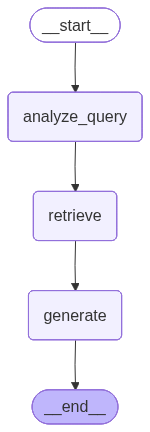

In [42]:
def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='68985837-c53c-45cb-a9b6-94a2a8c95e3f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 32987, 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lowe

## 7.3 Chatbot RAG

#### 7.3.1 Retrieval Tool

In this section, we will allow users to chat with the LLM about the document. In order to do this, we need to enable to preserve a history of the conversation

Earlier we saw that LangGraph could automated storing message history with:
```python
workflow = StateGraph(state_schema=MessagesState)
```

- User input is represented as `HumanMessage`
- The LLM response is represented as an `AIMessage`

We can extend this approach for RAG as follows:

1. User input as a `HumanMessage` (same as before);
2. Vector store query as an `AIMessage` with tool calls;
3. Retrieved documents as a `ToolMessage`;
4. Final response as a `AIMessage` (as before)

**In simpler words, rather than providing the documents in the state as we did in the previous section, we provide the LLM with a tool to retrieve the relevant documents when necessary.**

This has the benefit that: 

1. The LLM does not invoke the tool when a direct response is sufficient e.g. in response to a generic greeting from the user).

2. More importantly, **Leveraging tool-calling to interact with a retrieval step (step 3) has the benefit that the query for the retrieval is generated by our model.**

    This is especially important in a conversational setting, where user queries may require contextualization based on the chat history. For instance, consider the following exchange:

        Human: "What is Task Decomposition?"

        AI: "Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable for an agent or model."

        Human: "What are common ways of doing it?"

    In this scenario, a model could generate a query such as "common approaches to task decomposition". Tool-calling facilitates this naturally. 

    **As in the query analysis section of the RAG tutorial, this allows a model to rewrite user queries into more effective search queries.**



Let's start by building a custom tool that can perform the retrieval. See [this](https://python.langchain.com/docs/how_to/custom_tools/) guide for more detail on creating tools.

In [46]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

What will our graph look like in this case?

![](./docs/rag-chatbot-graph.png)

The `query_or_respond` node decides whether a tool call is necessary or not.
- If a tool call is necessary, call the retrieval tool and generate a reponse.
- If a tool call is not necessary (e.g. the user just said 'Hi'), respond directly.

The implementation is as follows:

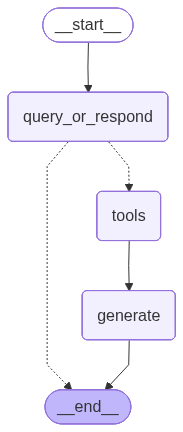

In [48]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(MessagesState)

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}


from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [50]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Vui3mZ9zEXLRVZf6k5rg9i17)
 Call ID: call_Vui3mZ9zEXLRVZf6k5rg9i17
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Langua

#### 7.3.2 Chat History 